# 1.8a: Core Definition

**The Discovery:** 2,179 tokens (96.9% of the cluster) occupy the exact same point in 2560D space at radius r = 0.00007553 from the cluster centroid.

**The Hypothesis:** This "point" is actually a superposition of 13 discrete black holes (from prior analysis) that we can't resolve at cluster scale.

**The Goal:** Define the core, compute its centroid, project to spherical coordinates centered at the core centroid, and look for black hole structure.

---

## Phase Transition

- **Phase 1.7:** Studied the cluster (2,248 tokens)
- **Phase 1.8:** Studying the core (2,179 tokens) - zooming in to resolve black holes

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Magic radius that defines the core
MAGIC_RADIUS = 0.00007553
RADIUS_TOLERANCE = 1e-7

# Visualization
DPI = 200
N_BINS = 100

## Imports

In [2]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file
from pathlib import Path

## Load Data

In [3]:
# Load W
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W = load_file(W_path)["W"].to(torch.float32)

print(f"Loaded W from {W_path}")
print(f"  Shape: {W.shape}")

# Load cluster data
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_mask.safetensors")
cluster_data = load_file(cluster_path)
cluster_mask = cluster_data["cluster_mask"].to(torch.bool)
cluster_token_ids = cluster_data["cluster_token_ids"].to(torch.int64)

print(f"\nLoaded cluster from {cluster_path}")
print(f"  Cluster size: {cluster_mask.sum().item():,} tokens")

# Load cluster spherical coords
spherical_path = Path(f"../tensors/{MODEL_NAME}/1.7c_cluster_spherical.safetensors")
spherical_data = load_file(spherical_path)
r_cluster = spherical_data["r"]

print(f"\nLoaded cluster spherical coords from {spherical_path}")

Loaded W from ../tensors/Qwen3-4B-Instruct-2507/W.safetensors
  Shape: torch.Size([151936, 2560])

Loaded cluster from ../tensors/Qwen3-4B-Instruct-2507/1.6a_cluster_mask.safetensors
  Cluster size: 2,248 tokens

Loaded cluster spherical coords from ../tensors/Qwen3-4B-Instruct-2507/1.7c_cluster_spherical.safetensors


## Define the Core

In [4]:
print("\nDefining the core...\n")

# Core = tokens at magic radius within cluster
core_mask_within_cluster = torch.abs(r_cluster - MAGIC_RADIUS) < RADIUS_TOLERANCE
n_core = core_mask_within_cluster.sum().item()

# Get core token IDs
core_token_ids = cluster_token_ids[core_mask_within_cluster]

print(f"Core definition:")
print(f"  Radius: {MAGIC_RADIUS} ± {RADIUS_TOLERANCE}")
print(f"  Core size: {n_core:,} tokens")
print(f"  Percentage of cluster: {n_core/len(cluster_token_ids)*100:.1f}%")
print(f"\nCore token ID range:")
print(f"  Min: {core_token_ids.min().item():,}")
print(f"  Max: {core_token_ids.max().item():,}")


Defining the core...

Core definition:
  Radius: 7.553e-05 ± 1e-07
  Core size: 2,179 tokens
  Percentage of cluster: 96.9%

Core token ID range:
  Min: 124
  Max: 151,935


## Extract Core Embeddings

In [5]:
print("\nExtracting core embeddings...\n")

# Create global mask (in full vocabulary space)
core_mask_global = torch.zeros(W.shape[0], dtype=torch.bool)
core_mask_global[core_token_ids] = True

# Extract embeddings
W_core = W[core_mask_global]

print(f"✓ Extracted {W_core.shape[0]:,} core embeddings")
print(f"  Dimensionality: {W_core.shape[1]:,}")


Extracting core embeddings...

✓ Extracted 2,179 core embeddings
  Dimensionality: 2,560


## Compute Core Centroid

In [6]:
print("\nComputing core centroid...\n")

# Core centroid (mean of core embeddings)
core_centroid = W_core.mean(dim=0)
core_centroid_norm = core_centroid.norm().item()

print(f"Core centroid:")
print(f"  Norm: {core_centroid_norm:.8f}")
print(f"\n✓ Core centroid computed")


Computing core centroid...

Core centroid:
  Norm: 0.37091690

✓ Core centroid computed


## Center Core at Its Centroid

In [7]:
print("\nCentering core at its centroid...\n")

# Center at core centroid
W_core_centered = W_core - core_centroid

# Verify centering
mean_norm = W_core_centered.mean(dim=0).norm().item()

print(f"✓ Centered core at its centroid")
print(f"  Mean of centered core: {mean_norm:.2e} (should be ~0)")


Centering core at its centroid...

✓ Centered core at its centroid
  Mean of centered core: 9.86e-10 (should be ~0)


## Find High-Variance Dimensions in Core

In [8]:
print("\nFinding high-variance dimensions in core...\n")

# Compute variance per dimension
variances = W_core_centered.var(dim=0)

# Find top 3 dimensions
top_indices = variances.argsort(descending=True)[:3]

# Assign to spherical basis (2, 1, 3 convention)
north_idx = top_indices[1].item()
meridian_idx = top_indices[0].item()
equinox_idx = top_indices[2].item()

print(f"Top 3 dimensions by variance (in core):")
print(f"  Meridian (1st): dimension {meridian_idx}, variance = {variances[meridian_idx].item():.2e}")
print(f"  North (2nd):    dimension {north_idx}, variance = {variances[north_idx].item():.2e}")
print(f"  Equinox (3rd):  dimension {equinox_idx}, variance = {variances[equinox_idx].item():.2e}")

print(f"\n✓ Identified basis dimensions for core")


Finding high-variance dimensions in core...

Top 3 dimensions by variance (in core):
  Meridian (1st): dimension 322, variance = 2.33e-10
  North (2nd):    dimension 163, variance = 1.09e-10
  Equinox (3rd):  dimension 1564, variance = 5.77e-11

✓ Identified basis dimensions for core


## Project Core to Spherical Coordinates

In [9]:
print("\nProjecting core to spherical coordinates...\n")

# Extract Cartesian coordinates
x = W_core_centered[:, meridian_idx]
y = W_core_centered[:, equinox_idx]
z = W_core_centered[:, north_idx]

# Compute radius
r_core = torch.sqrt(x**2 + y**2 + z**2)

# Latitude
lat_rad = torch.asin(torch.clamp(z / (r_core + 1e-10), -1, 1))  # Add epsilon to avoid div by zero
lat_deg = torch.rad2deg(lat_rad)

# Longitude
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"✓ Computed spherical coordinates for core")
print(f"\nRadius statistics:")
print(f"  Min: {r_core.min().item():.2e}")
print(f"  Max: {r_core.max().item():.2e}")
print(f"  Median: {r_core.median().item():.2e}")
print(f"  Mean: {r_core.mean().item():.2e}")
print(f"\nLatitude range: [{lat_deg.min().item():.2f}°, {lat_deg.max().item():.2f}°]")
print(f"Longitude range: [{lon_deg.min().item():.2f}°, {lon_deg.max().item():.2f}°]")


Projecting core to spherical coordinates...

✓ Computed spherical coordinates for core

Radius statistics:
  Min: 1.64e-05
  Max: 4.88e-04
  Median: 1.71e-05
  Mean: 1.72e-05

Latitude range: [-88.00°, 0.78°]
Longitude range: [-155.16°, 150.66°]


## Radius Histogram: Looking for Black Holes


Plotting radius distribution (looking for black hole structure)...



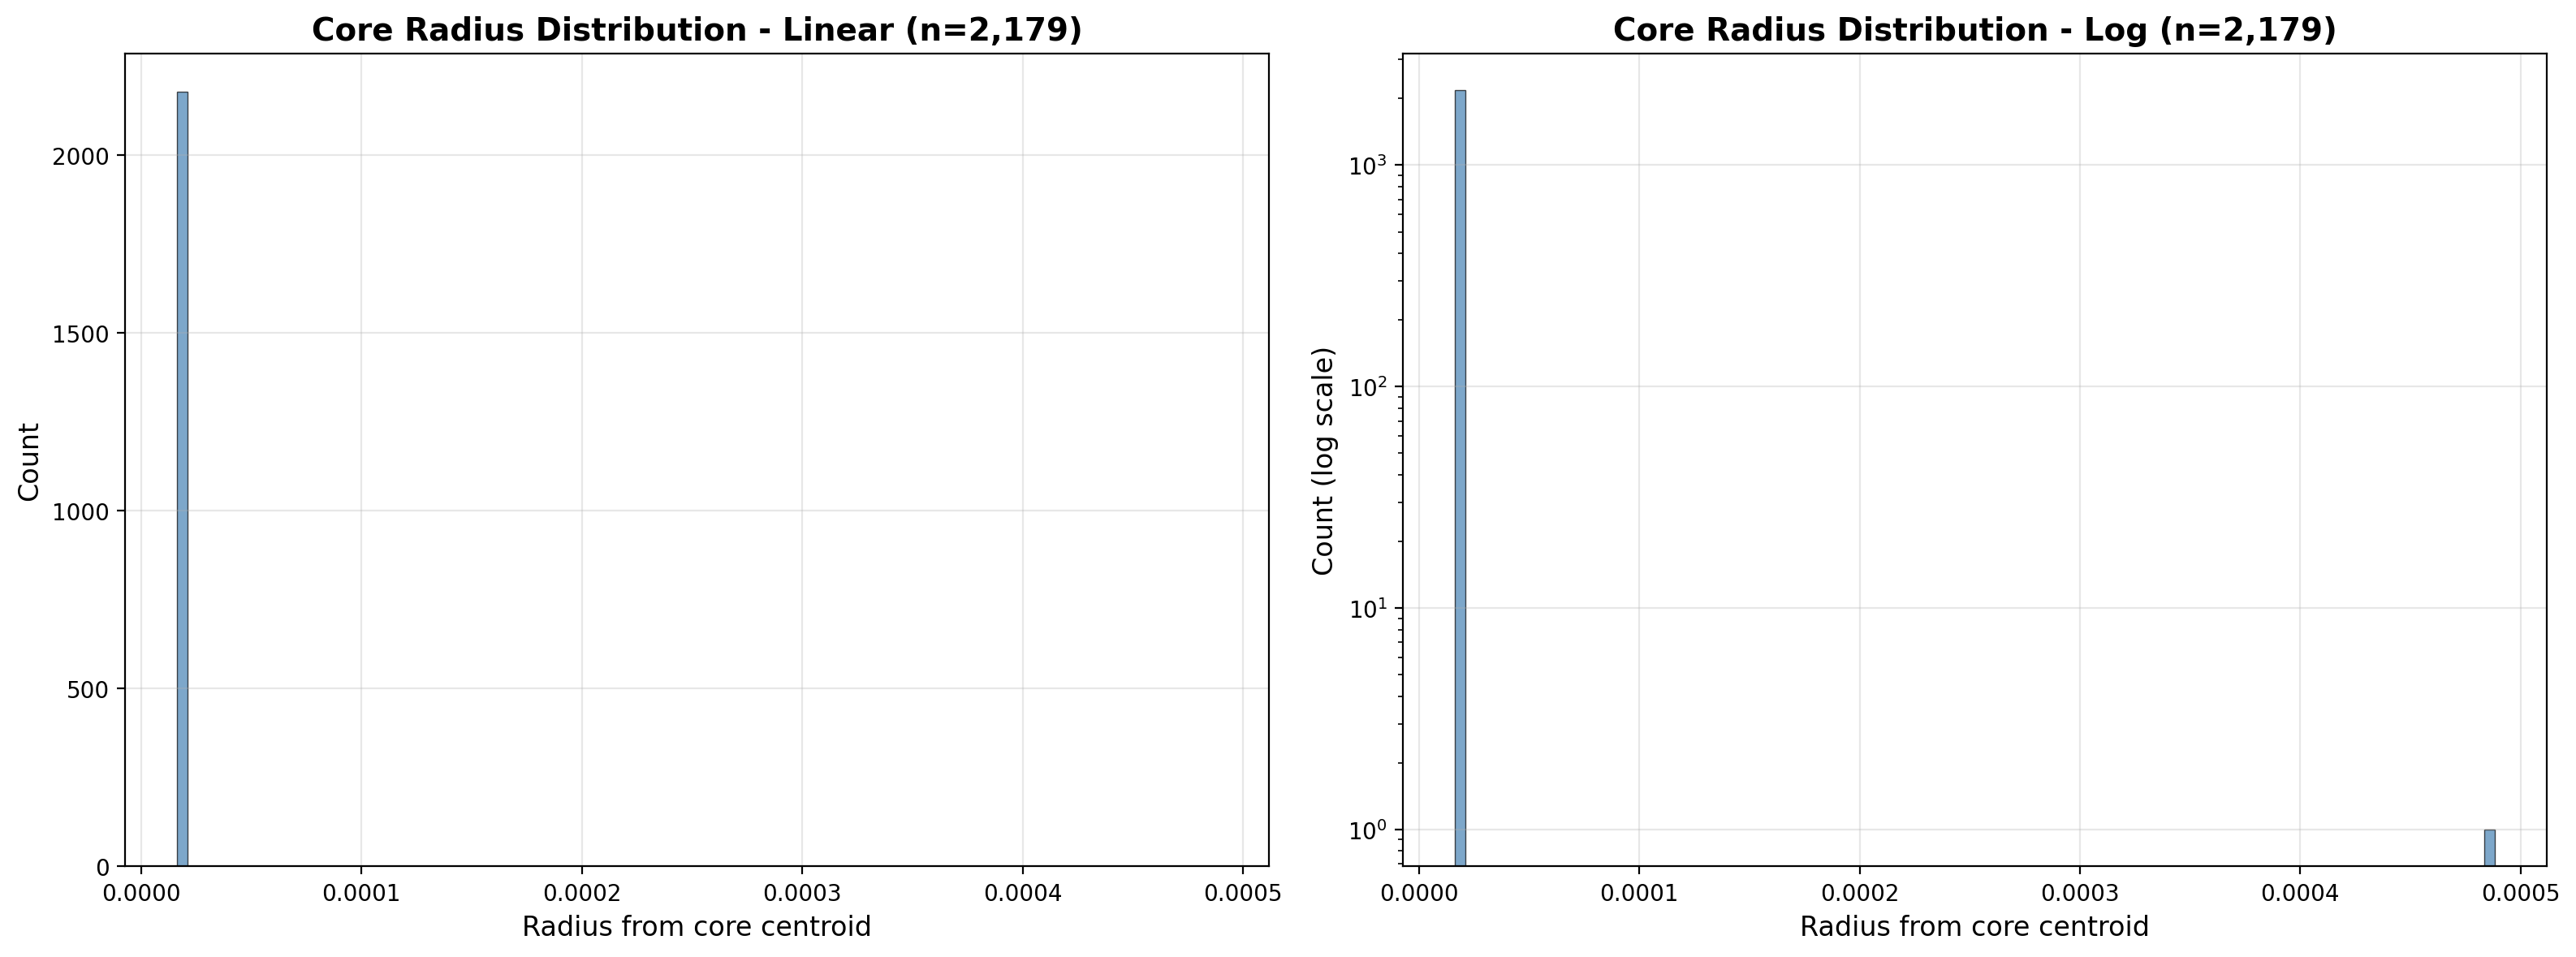

✓ Plotted radius distribution

Looking for discrete spikes = black holes (multiple tokens at same radius)


In [10]:
print("\nPlotting radius distribution (looking for black hole structure)...\n")

r_core_np = r_core.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Linear scale
ax1.hist(r_core_np, bins=N_BINS, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Radius from core centroid', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'Core Radius Distribution - Linear (n={n_core:,})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Log scale
ax2.hist(r_core_np, bins=N_BINS, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Radius from core centroid', fontsize=12)
ax2.set_ylabel('Count (log scale)', fontsize=12)
ax2.set_title(f'Core Radius Distribution - Log (n={n_core:,})', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Plotted radius distribution")
print("\nLooking for discrete spikes = black holes (multiple tokens at same radius)")

## Unique Radius Analysis

In [11]:
print("\nAnalyzing unique radius values...\n")

# Find unique radii and their counts
unique_radii, counts = torch.unique(r_core, return_counts=True)

# Sort by count (descending)
sort_idx = counts.argsort(descending=True)
unique_radii_sorted = unique_radii[sort_idx]
counts_sorted = counts[sort_idx]

print(f"Total unique radius values: {len(unique_radii):,}")
print(f"\nTop 20 most populous radii (candidate black holes):")
print(f"{'Rank':<6} {'Radius':<18} {'Count':<10} {'% of core'}")
print("-" * 55)

for rank in range(min(20, len(unique_radii_sorted))):
    radius = unique_radii_sorted[rank].item()
    count = counts_sorted[rank].item()
    pct = count / n_core * 100
    
    marker = " ← BLACK HOLE" if count > 1 else ""
    print(f"{rank+1:<6} {radius:<18.10e} {count:<10,} {pct:>5.1f}%{marker}")


Analyzing unique radius values...

Total unique radius values: 5

Top 20 most populous radii (candidate black holes):
Rank   Radius             Count      % of core
-------------------------------------------------------
1      1.6406491341e-05   866         39.7% ← BLACK HOLE
2      1.7730499167e-05   734         33.7% ← BLACK HOLE
3      1.7082888007e-05   329         15.1% ← BLACK HOLE
4      1.7079768440e-05   249         11.4% ← BLACK HOLE
5      4.8835645430e-04   1            0.0%


## Sky Map: Core Structure


Plotting core sky map...



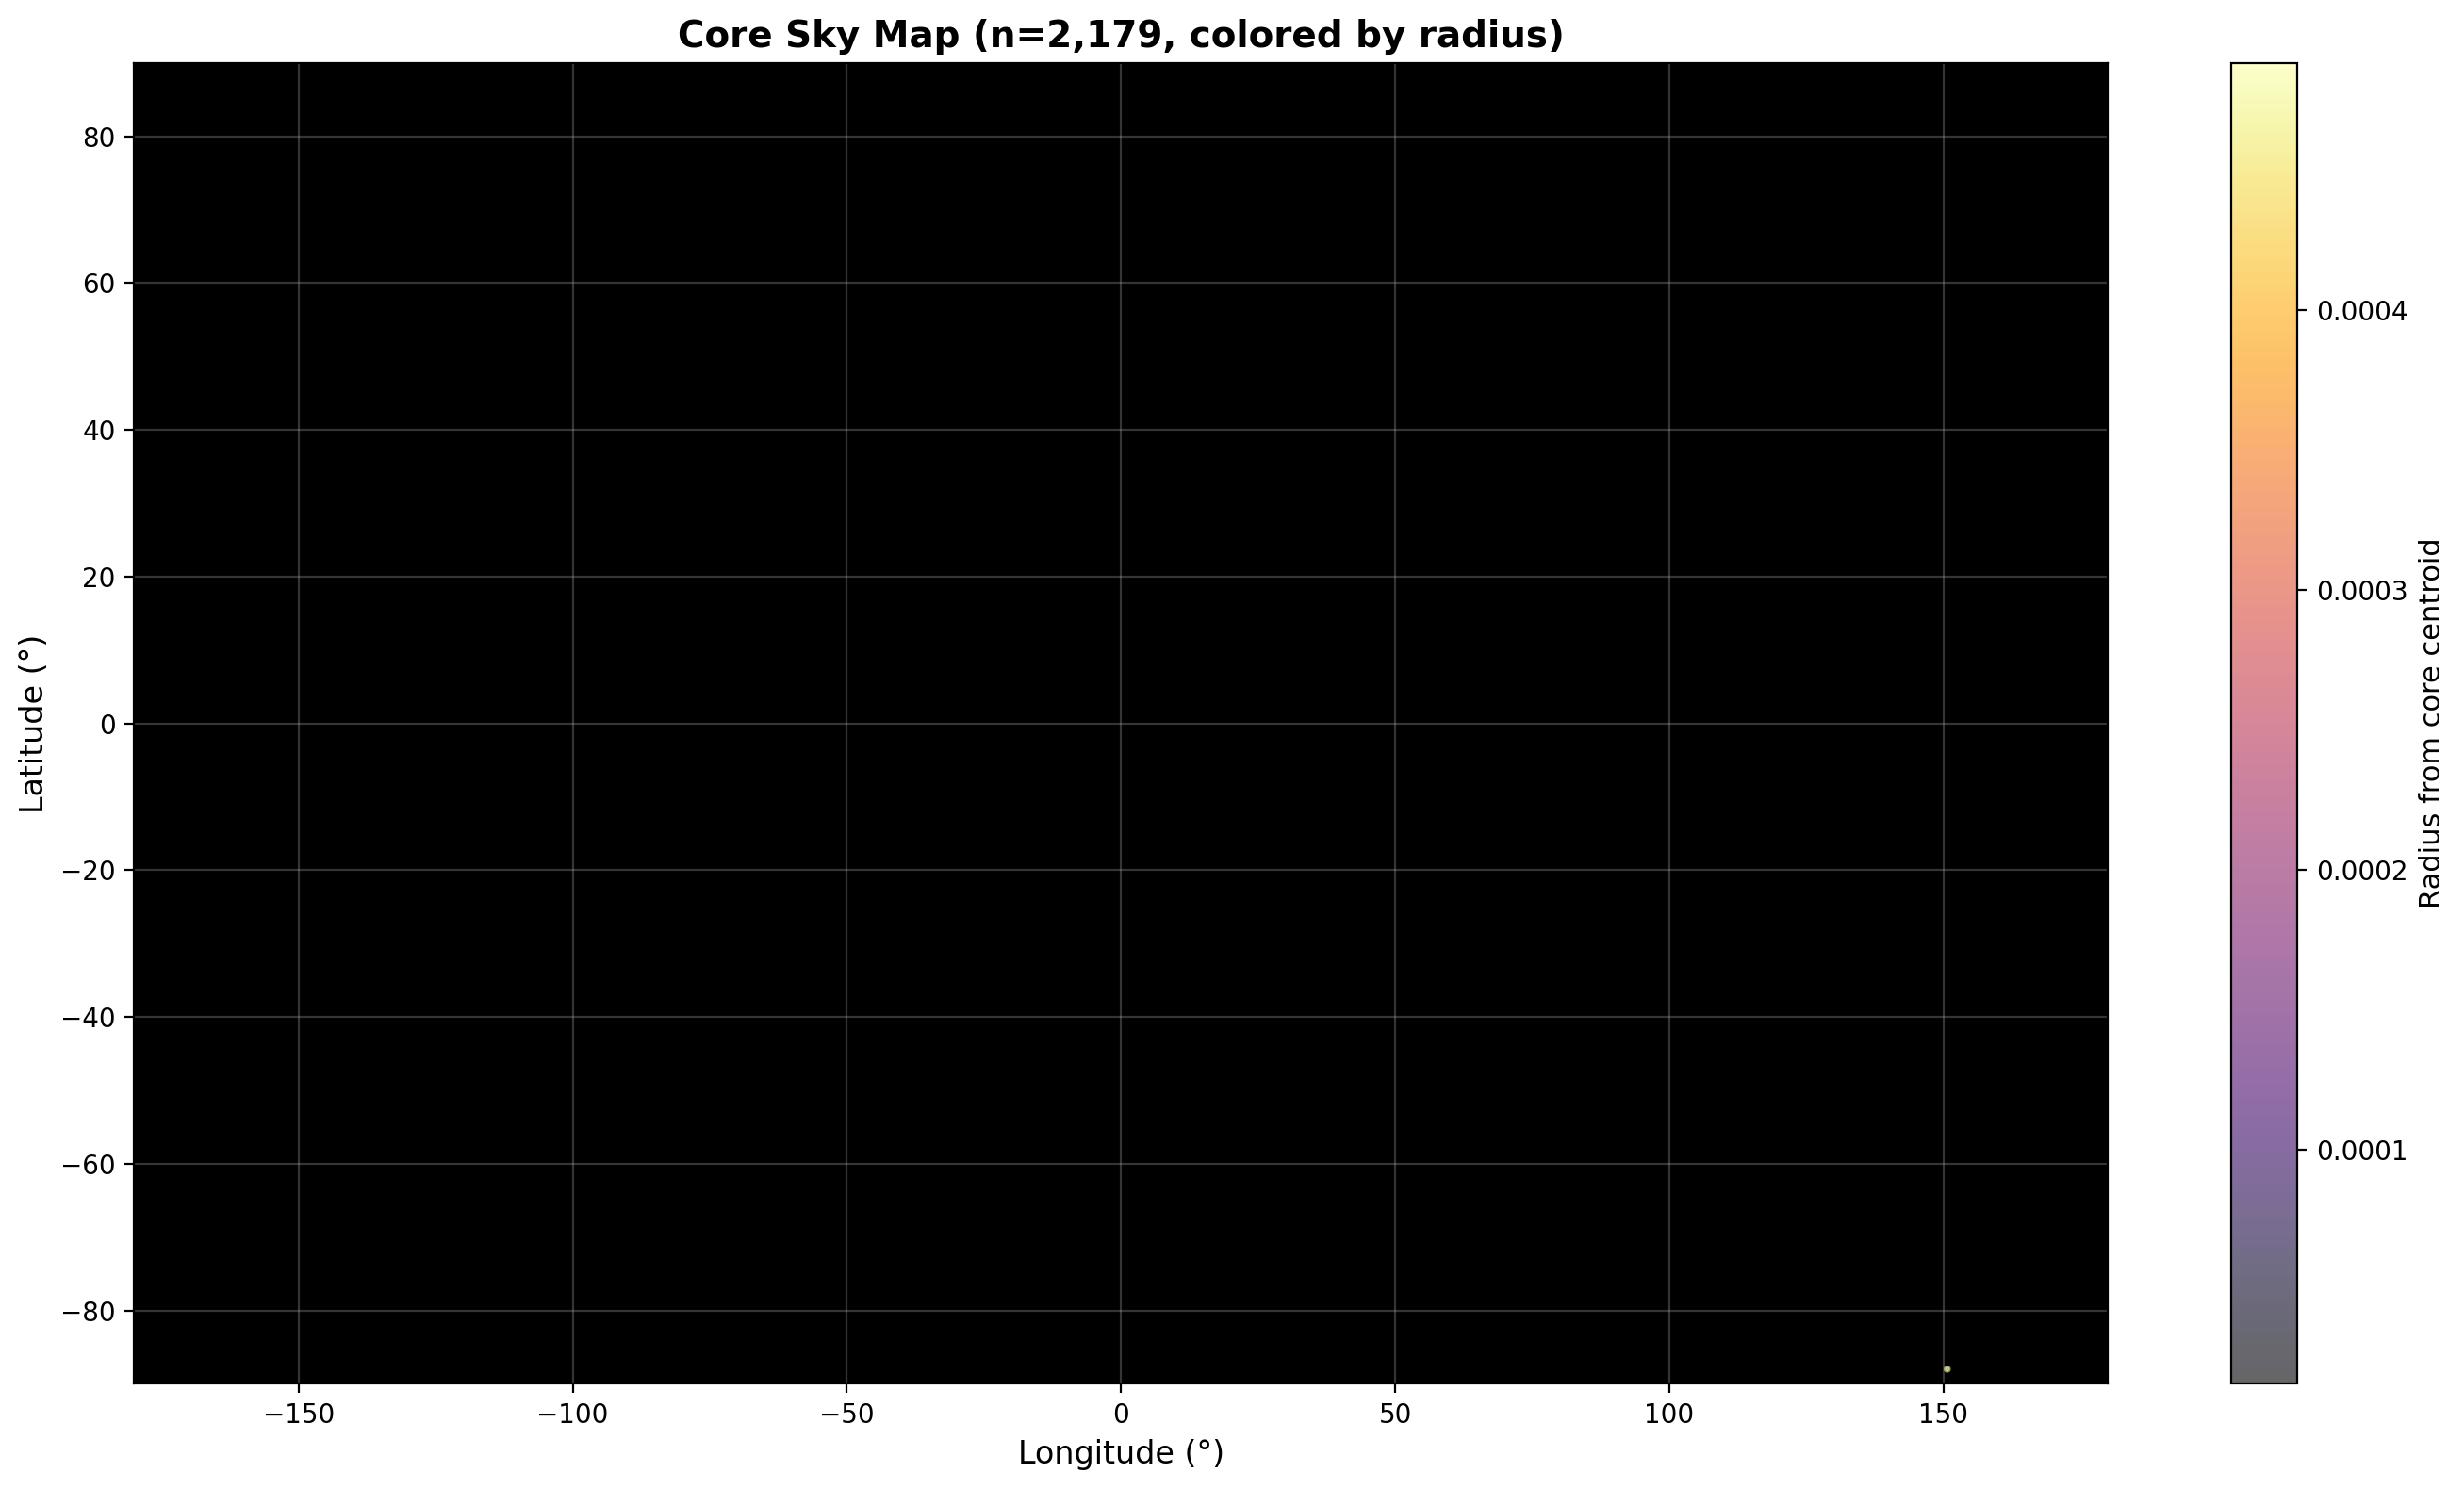

✓ Plotted core sky map


In [14]:
print("\nPlotting core sky map...\n")

fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

ax.set_facecolor('black')

# Scatter plot colored by radius
scatter = ax.scatter(lon_deg.numpy(), lat_deg.numpy(), 
                     c=r_core.numpy(), cmap='inferno', s=3, alpha=0.6)

ax.set_xlabel('Longitude (°)', fontsize=12)
ax.set_ylabel('Latitude (°)', fontsize=12)
ax.set_title(f'Core Sky Map (n={n_core:,}, colored by radius)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Radius from core centroid', fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Plotted core sky map")

## Save Core Data

In [15]:
print("\nSaving core definition and spherical coordinates...\n")

output_path = Path(f"../tensors/{MODEL_NAME}/1.8a_core.safetensors")
output_path.parent.mkdir(parents=True, exist_ok=True)

save_file({
    # Core definition
    "core_mask": core_mask_global.to(torch.uint8),
    "core_token_ids": core_token_ids.to(torch.int32),
    "n_core": torch.tensor([n_core], dtype=torch.int32),
    
    # Core centroid
    "core_centroid": core_centroid,
    
    # Spherical coordinates (centered at core centroid)
    "r": r_core,
    "lat_deg": lat_deg,
    "lon_deg": lon_deg,
    
    # Basis indices
    "north_idx": torch.tensor([north_idx], dtype=torch.int32),
    "meridian_idx": torch.tensor([meridian_idx], dtype=torch.int32),
    "equinox_idx": torch.tensor([equinox_idx], dtype=torch.int32),
}, str(output_path))

print(f"✓ Saved to {output_path}")
print()
print("Saved tensors:")
print(f"  core_mask: (151936,) - binary mask in full vocabulary")
print(f"  core_token_ids: ({n_core},) - token IDs")
print(f"  core_centroid: (2560,) - mean embedding of core")
print(f"  r, lat_deg, lon_deg: ({n_core},) each - spherical coords")
print(f"  basis indices: dimensions {meridian_idx}, {north_idx}, {equinox_idx}")


Saving core definition and spherical coordinates...

✓ Saved to ../tensors/Qwen3-4B-Instruct-2507/1.8a_core.safetensors

Saved tensors:
  core_mask: (151936,) - binary mask in full vocabulary
  core_token_ids: (2179,) - token IDs
  core_centroid: (2560,) - mean embedding of core
  r, lat_deg, lon_deg: (2179,) each - spherical coords
  basis indices: dimensions 322, 163, 1564
